In [3]:
import torch
from torchvision import models, transforms
from PIL import Image

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4060


In [6]:
from pillow_heif import register_heif_opener

register_heif_opener()

In [38]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model.eval()

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure 3-channel RGB image
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(input_tensor).squeeze()  # Remove unnecessary dimensions
    return features.numpy()  # Convert to NumPy for easier handling

In [39]:
import os
def count_images(folder_path, extensions=('.heic')):
    # List all files in the folder
    files = os.listdir(folder_path)
    # Filter only image files by checking their extensions
    image_files = [file for file in files if file.lower().endswith(extensions)]
    return len(image_files), image_files

count, images = count_images('sample_pics')

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

features = [extract_features(os.path.join('sample_pics', image)) for image in images]
similarities = cosine_similarity(features)

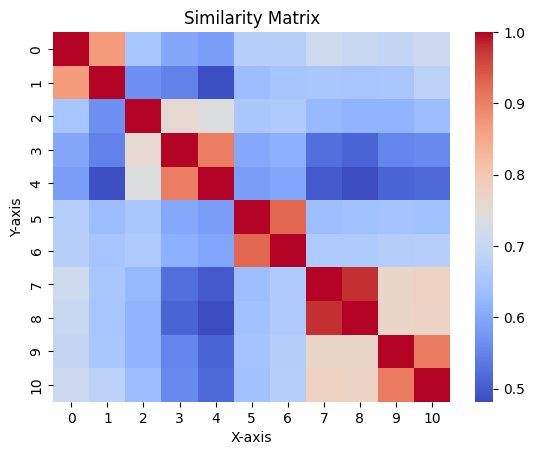

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(similarities, annot=False, cmap='coolwarm', cbar=True)  # 'coolwarm' colormap is another option
plt.title('Similarity Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [49]:
from sklearn.cluster import DBSCAN

distance_matrix = np.abs(1 - similarities)
clustering = DBSCAN(metric='precomputed', eps=0.1, min_samples=2).fit(distance_matrix)

# Output cluster labels
print("Cluster Labels:", clustering.labels_)

Cluster Labels: [-1 -1 -1  0  0  1  1  2  2  3  3]
